In [13]:
import os
from PIL import Image
import torch
import numpy as np
import pytorch_lightning as pl
import torchvision.transforms as tf
import tensorflow as tf
import glob
import random
from configobj import ConfigObj

In [53]:
# TRAIN_0000부터 TRAIN_6991까지 모든 이미지에 대한 경로 생성
train_image_paths = [
    r'C:\Users\82106\Desktop\데이콘\이미지 학습\데이터\open\train\TRAIN_{:04}.png'.format(i)
    for i in range(6992)
]

###  RGB -> YCbCr 전처리 함수

In [54]:
import torch

def rgb2ycbcr(image):
    # image는 Tensor이며, shape은 (C, H, W) 또는 (N, C, H, W)
    if image.dim() == 3:
        # (C, H, W)인 경우
        R = image[0, :, :]
        G = image[1, :, :]
        B = image[2, :, :]
    elif image.dim() == 4:
        # (N, C, H, W)인 경우
        R = image[:, 0, :, :]
        G = image[:, 1, :, :]
        B = image[:, 2, :, :]
    else:
        raise ValueError('Unsupported image dimensions')

    X = 0.299 * R + 0.587 * G + 0.114 * B
    Y = (R - X) * 0.713 + 128
    Z = (B - X) * 0.564 + 128

    if image.dim() == 3:
        X = X.unsqueeze(0)
        Y = Y.unsqueeze(0)
        Z = Z.unsqueeze(0)
        ycbcr = torch.cat([X, Y, Z], dim=0)
    else:
        X = X.unsqueeze(1)
        Y = Y.unsqueeze(1)
        Z = Z.unsqueeze(1)
        ycbcr = torch.cat([X, Y, Z], dim=1)
    return ycbcr


### 이미지 데이터 형태 변환

In [55]:
from PIL import Image
import numpy as np
import torch

def load_and_preprocess_image(path):
    try:
        # 이미지 파일 열기
        image = Image.open(path).convert('RGB')
        # 이미지 리사이즈
        image = image.resize((224, 224))
        # 이미지를 numpy 배열로 변환하고 float32로 변환
        image_array = np.array(image).astype('float32')
        # 정규화 (0-1 스케일링)
        image_array /= 255.0
        # numpy 배열을 torch.Tensor로 변환하고 차원 순서 변경 (HWC -> CHW)
        image_tensor = torch.from_numpy(image_array).permute(2, 0, 1)
        # rgb2ycbcr 변환 적용
        image_tensor = rgb2ycbcr(image_tensor)
        return image_tensor
    except Exception as e:
        print(f"Error processing image {path}: {e}")
        return None


In [56]:
def init_parameters():
    class Config:
        pass

    # 훈련 및 검증 설정 초기화
    train_config = Config()
    valid_config = Config()
    
    train_config.is_training = True
    valid_config.is_training = False
    train_config.batch_size = 12
    valid_config.batch_size = 12
    train_config.n_channels = 16
    valid_config.n_channels = 16
    train_config.image_size = 256
    valid_config.image_size = 256
    train_config.n_threads = 2
    valid_config.n_threads = 1
    train_config.n_blocks = 5
    valid_config.n_blocks = 5
    train_config.n_levels = 4
    valid_config.n_levels = 4
    train_config.checkpoint = 1000
    train_config.q_limit = 1000
    train_config.lamda = 2000.0
    valid_config.q_limit = 500
    
    return train_config, valid_config

In [57]:
# 모델 학습 파라미터 초기화
train_config, valid_config = init_parameters()
patch_size = train_config.image_size
valid_config.q_limit = 500

### train.csv 데이터

In [58]:
import numpy as np
import pandas as pd
from tqdm import tqdm

train_df = pd.read_csv(r'C:\Users\82106\Desktop\데이콘\이미지 학습\데이터\open\train.csv')
gene_columns = train_df.columns.drop(['ID', 'path'])
labels = train_df[gene_columns].values.astype(np.float32)

In [59]:
# 모든 이미지 전처리 수행
normalized_images = []
train_images = []  # 빈 리스트로 초기화
for path in tqdm(train_image_paths):
    image_tensor = load_and_preprocess_image(path)
    if image_tensor is not None:
        train_images.append(image_tensor)  # 리스트에 이미지 추가

print(f"정규화된 이미지 개수: {len(train_images)}")

100%|██████████| 6992/6992 [00:29<00:00, 237.36it/s]

정규화된 이미지 개수: 6992


### 데이터 분할 및 이미지 tensor 형태로 변환

In [69]:
# 리스트를 Tensor로 변환
train_images = torch.stack(train_images)

In [70]:
from sklearn.model_selection import train_test_split

# 학습 및 검증 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.2, random_state=42)

In [82]:
# 리스트를 Tensor로 변환
X_train = torch.stack(list(X_train))
X_val = torch.stack(list(X_val))

y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# DataLoader 생성
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_config.batch_size,
    shuffle=True,
    num_workers=train_config.n_threads  # 데이터 로딩 속도 향상
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=valid_config.batch_size,
    shuffle=False,
    num_workers=valid_config.n_threads
)

C:\Users\82106\AppData\Local\Temp\ipykernel_31320\865082509.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
C:\Users\82106\AppData\Local\Temp\ipykernel_31320\865082509.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val = torch.tensor(y_val, dtype=torch.float32)


### CNN모델링 유전자 & 발현 정보 학습 레이어 포함

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

# CNN기반 경량화된 모델 사용 (MobileNetV2)
cnn_model = models.mobilenet_v2(pretrained=True)

# 사전 학습된 모델의 파라미터를 동결
for param in cnn_model.parameters():
    param.requires_grad = False

# 마지막 분류 계층 수정
num_genes = labels.shape[1]
cnn_model.classifier = nn.Sequential(
    nn.Dropout(0.2),

    #유전자 발현 정보 학습 레이어
    nn.Linear(cnn_model.last_channel, num_genes)
)

model = cnn_model

### 하이퍼파라미터 설정

In [85]:
# 손실 함수 및 옵티마이저 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=1e-4)  # 동결되지 않은 파라미터만 전달

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Mixed Precision Training 설정
scaler = torch.cuda.amp.GradScaler()


c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\cuda\amp\grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


### 훈련 루프 정의

In [ ]:
# 훈련 루프 정의
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50):
    best_val_loss = float('inf')
    patience = 3  # 조기 종료 기준
    counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():  # Mixed Precision Training
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        # 검증 손실 계산
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                with torch.cuda.amp.autocast():  # Mixed Precision Training
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

        # 모델 저장 및 조기 종료 체크
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print('Model saved.')
        else:
            counter += 1
            if counter >= patience:
                print('Early stopping.')
                break

#### 훈련루프 정의

1. **초기 설정**
   - 최적 검증 손실 초기화
   - 조기 종료를 위한 patience 설정 (3회)
   - 손실을 기록할 리스트 초기화

2. **훈련 단계**
   - 모델을 학습 모드로 전환
   - 각 배치에서 Mixed Precision Training을 통해 메모리 절약하며 손실 계산 및 역전파 수행
   - 모든 배치의 손실을 누적하여 에포크의 평균 훈련 손실 기록

3. **검증 단계**
   - 모델을 검증 모드로 전환하여 드롭아웃 비활성화
   - 손실을 계산하고 평균 검증 손실 기록

4. **모델 저장 및 조기 종료**
   - 검증 손실이 개선되면 최적 모델 저장
   - 검증 손실 개선이 없을 경우 counter 증가
   - counter가 patience를 초과하면 조기 종료로 학습 중단


### 모델 훈련

In [87]:
# 모델 훈련
train_model(model, criterion, optimizer, train_loader, val_loader)

  0%|          | 0/467 [00:00<?, ?it/s]c:\Users\82106\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\amp\autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
100%|██████████| 467/467 [02:28<00:00,  3.15it/s]


Epoch 1/50, Loss: 0.1056, Val Loss: 0.0656
Model saved.


100%|██████████| 467/467 [02:34<00:00,  3.02it/s]


Epoch 2/50, Loss: 0.0823, Val Loss: 0.0589
Model saved.


100%|██████████| 467/467 [02:26<00:00,  3.19it/s]


Epoch 3/50, Loss: 0.0731, Val Loss: 0.0555
Model saved.


100%|██████████| 467/467 [02:33<00:00,  3.04it/s]


Epoch 4/50, Loss: 0.0669, Val Loss: 0.0536
Model saved.


100%|██████████| 467/467 [02:35<00:00,  3.00it/s]


Epoch 5/50, Loss: 0.0625, Val Loss: 0.0522
Model saved.


100%|██████████| 467/467 [02:27<00:00,  3.16it/s]


Epoch 6/50, Loss: 0.0591, Val Loss: 0.0517
Model saved.


100%|██████████| 467/467 [02:21<00:00,  3.30it/s]


Epoch 7/50, Loss: 0.0566, Val Loss: 0.0507
Model saved.


100%|██████████| 467/467 [02:28<00:00,  3.14it/s]


Epoch 8/50, Loss: 0.0546, Val Loss: 0.0502
Model saved.


100%|██████████| 467/467 [02:29<00:00,  3.13it/s]


Epoch 9/50, Loss: 0.0530, Val Loss: 0.0500
Model saved.


100%|██████████| 467/467 [02:29<00:00,  3.12it/s]


Epoch 10/50, Loss: 0.0518, Val Loss: 0.0500
Model saved.


100%|██████████| 467/467 [02:29<00:00,  3.12it/s]


Epoch 11/50, Loss: 0.0509, Val Loss: 0.0496
Model saved.


100%|██████████| 467/467 [02:29<00:00,  3.12it/s]


Epoch 12/50, Loss: 0.0502, Val Loss: 0.0496
Model saved.


100%|██████████| 467/467 [02:28<00:00,  3.14it/s]


Epoch 13/50, Loss: 0.0498, Val Loss: 0.0497


100%|██████████| 467/467 [02:28<00:00,  3.14it/s]


Epoch 14/50, Loss: 0.0493, Val Loss: 0.0495
Model saved.


100%|██████████| 467/467 [02:28<00:00,  3.14it/s]


Epoch 15/50, Loss: 0.0490, Val Loss: 0.0494
Model saved.


100%|██████████| 467/467 [02:29<00:00,  3.12it/s]


Epoch 16/50, Loss: 0.0487, Val Loss: 0.0495


100%|██████████| 467/467 [02:30<00:00,  3.10it/s]


Epoch 17/50, Loss: 0.0484, Val Loss: 0.0493
Model saved.


100%|██████████| 467/467 [02:30<00:00,  3.11it/s]


Epoch 18/50, Loss: 0.0483, Val Loss: 0.0493


100%|██████████| 467/467 [02:28<00:00,  3.14it/s]


Epoch 19/50, Loss: 0.0481, Val Loss: 0.0492
Model saved.


100%|██████████| 467/467 [02:30<00:00,  3.11it/s]


Epoch 20/50, Loss: 0.0480, Val Loss: 0.0493


100%|██████████| 467/467 [02:28<00:00,  3.16it/s]


Epoch 21/50, Loss: 0.0479, Val Loss: 0.0492


100%|██████████| 467/467 [02:28<00:00,  3.14it/s]


Epoch 22/50, Loss: 0.0478, Val Loss: 0.0490
Model saved.


100%|██████████| 467/467 [02:28<00:00,  3.15it/s]


Epoch 23/50, Loss: 0.0477, Val Loss: 0.0491


100%|██████████| 467/467 [02:28<00:00,  3.14it/s]


Epoch 24/50, Loss: 0.0476, Val Loss: 0.0492


100%|██████████| 467/467 [02:27<00:00,  3.16it/s]


Epoch 25/50, Loss: 0.0476, Val Loss: 0.0492
Early stopping.


In [117]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 모델 성능 평가
def evaluate_model(model, val_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
            actuals.append(labels.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    # 성능 지표 계산
    mse = mean_squared_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-squared (R2): {r2:.4f}")

    # 예측과 실제 값을 시각화
    plt.figure(figsize=(10, 5))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted Values')
    plt.show()

Mean Squared Error (MSE): 0.0492
R-squared (R2): -1280.2196


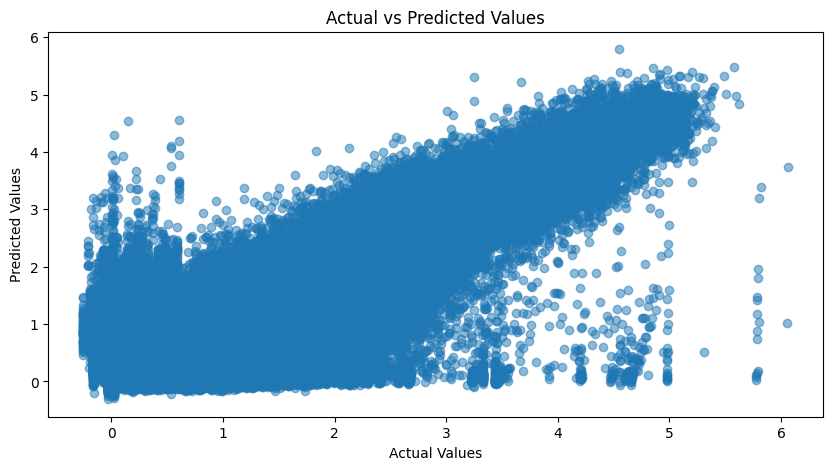

In [118]:
# 모델 성능 평가 호출
evaluate_model(model, val_loader)

- **분포 모양**: 예측값이 실제값 근처에 있지만, 데이터가 흩어져 있어 상관관계가 약함
- **오차 영역**: 고값 영역에서 예측 정확도가 낮고 분산이 큼
- **선형 관계 부족**: 45도 대각선에서 벗어난 예측이 많아 모델 편향 가능성

# 테스트 데이터 추론

In [92]:
# 테스트 이미지 경로 생성
test_image_paths = [
    r'C:\Users\82106\Desktop\데이콘\이미지 학습\데이터\open\test\TEST_{:04}.png'.format(i)
    for i in range(2277)
]

### 테스트 데이터 전처리

In [ ]:
# 테스트 데이터 전처리 및 DataLoader
test_images = []
for path in tqdm(test_image_paths):
    image_tensor = load_and_preprocess_image(path)
    if image_tensor is not None:
        test_images.append(image_tensor)

test_images = torch.stack(test_images)

test_dataset = torch.utils.data.TensorDataset(test_images)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=valid_config.batch_size, shuffle=False)

100%|██████████| 2277/2277 [00:42<00:00, 53.22it/s]


### 추론 함수 정의

In [94]:
# 테스트 데이터에 대한 유전자 발현 정보 추론 함수
def predict_gene_expression(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs in tqdm(test_loader):
            inputs = inputs[0].to(device)
            outputs = model(inputs)
            predictions.append(outputs.cpu().numpy())
    predictions = np.concatenate(predictions, axis=0)
    return predictions

### 추론

In [95]:
# 테스트 데이터에 대한 예측 수행
test_predictions = predict_gene_expression(model, test_loader)

100%|██████████| 190/190 [00:43<00:00,  4.33it/s]


### 결과를 데이터 프레임으로 저장

In [97]:
# 결과를 데이터프레임으로 저장
sample_submission_path = r'C:\Users\82106\Desktop\데이콘\이미지 학습\데이터\open\sample_submission.csv'
sample_submission = pd.read_csv(sample_submission_path)

In [98]:
# 열 이름 리스트 추출
submission_columns = sample_submission.columns.tolist()

In [105]:
#  예측 결과를 DataFrame으로 생성
pred_df = pd.DataFrame(test_predictions, columns=submission_columns[1:])

In [107]:
test_image_ids = []

for image_path in test_image_paths:
    image_id = os.path.basename(image_path).split('.')[0]
    test_image_ids.append(image_id)

In [108]:
# 'ID' 열 추가
pred_df.insert(0, 'ID', test_image_ids)

In [109]:
# 열 순서 맞추기 (sample_submission.csv와 동일하게)
pred_df = pred_df[sample_submission.columns]

In [110]:
pred_df

,ID,AL645608.7,HES4,TNFRSF18,TNFRSF4,SDF4,ACAP3,INTS11,MXRA8,AL391244.2,...,MT-ATP8,MT-ATP6,MT-CO3,MT-ND3,MT-ND4L,MT-ND4,MT-ND5,MT-CYB,BX004987.1,AL592183.1
0,TEST_0000,0.009963,0.122968,0.017726,-0.010184,0.659493,0.082992,0.097268,0.034879,0.003540,...,0.235170,3.862041,3.982737,3.181158,1.359486,3.760260,1.580052,3.442345,0.027794,-0.008535
1,TEST_0001,0.011764,0.043183,0.009924,0.008895,0.644684,0.118878,0.240284,-0.017169,-0.018786,...,0.456486,3.082278,3.297927,2.582980,0.991278,3.135633,1.398719,2.869811,0.005809,0.022421
2,TEST_0002,-0.018728,0.067654,0.013112,0.014378,0.684463,0.182811,0.309224,0.064749,0.004519,...,0.241781,3.536777,3.723589,2.871158,1.050842,3.554796,1.496975,3.251728,0.008632,0.023132
3,TEST_0003,-0.000110,0.048685,0.003403,0.009400,0.611910,0.107072,0.207002,0.001469,-0.001785,...,0.176905,2.837038,3.019141,2.288028,0.677141,2.832756,1.140466,2.583953,0.003331,-0.000910
4,TEST_0004,0.001805,0.068487,-0.000615,-0.007040,0.720576,0.020694,0.137148,-0.026325,-0.020580,...,0.362357,3.555144,3.719625,3.186304,1.284143,3.463475,1.695590,3.230787,0.029154,0.009648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2272,TEST_2272,-0.012382,0.065804,-0.008330,-0.000790,0.801593,0.014893,0.328402,-0.018961,0.014256,...,0.347511,3.373519,3.508855,2.937503,1.068504,3.280492,1.330769,3.032022,0.015931,0.020866
2273,TEST_2273,0.004497,0.029301,0.015061,0.001855,0.642954,0.167230,0.123594,-0.066736,-0.020474,...,0.736833,3.992276,4.074471,3.442501,1.737662,3.995407,2.129244,3.582622,0.008370,0.016813
2274,TEST_2274,-0.010117,0.060834,0.004381,0.009756,0.654144,0.137568,0.178514,0.011214,-0.003311,...,0.313789,3.138010,3.208245,2.579027,0.846394,3.059098,1.266807,2.781508,0.005935,0.005726
2275,TEST_2275,0.002914,0.038057,0.000557,0.001432,0.647429,0.088411,0.144610,0.030398,-0.003570,...,0.117869,3.018812,3.087460,2.448882,0.642591,2.924597,0.926003,2.675950,0.007352,0.002037


In [112]:
#  제출 파일 저장
submission_file_path = r'C:\Users\82106\Desktop\데이콘\이미지 학습\데이터\open\submission.csv'
pred_df.to_csv(submission_file_path, index=False)